'''This script is refactored version of the one available on Keras's blog and uses data that can be downloaded from:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs

So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

In [95]:
import os
import numpy as np
from keras import applications, optimizers
from keras.layers import Input,Dense, Dropout, Flatten
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator

In [96]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = os.path.join(os.getcwd(), 'fc_model.h5')
train_data_dir = os.path.join(os.getcwd(), 'data', 'cats_and_dogs_small', 'train')
validation_data_dir = os.path.join(os.getcwd(), 'data', 'cats_and_dogs_small', 'validation')
img_width, img_height = 150, 150
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 4 #more than enough to get a good result
batch_size = 16

In [97]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
print('Reading vgg')
model = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
model.summary()

Reading vgg
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0        

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.

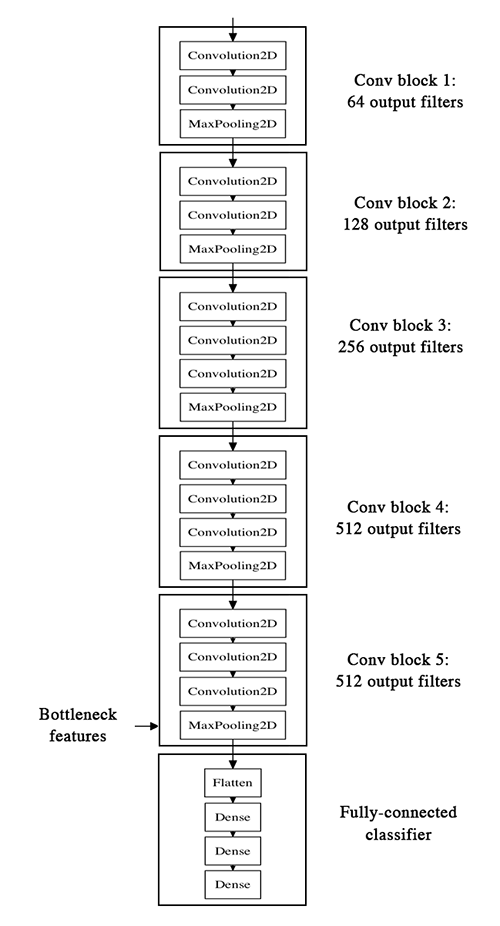

In [98]:
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
print('\nSaved bottleneck_features_train\n')

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size)

np.save('bottleneck_features_validation.npy',  bottleneck_features_validation)
print('\n--Saved bottleneck_features_validation--')

Found 2000 images belonging to 2 classes.

Augmentation complete

Saved bottleneck_features_train

Found 800 images belonging to 2 classes.

--Saved bottleneck_features_validation--


In [99]:
train_data = np.load('bottleneck_features_train.npy')

train_labels = np.array([0] * int(nb_train_samples/2 ) + [1] * int(nb_train_samples/2 ))

validation_data = np.load('bottleneck_features_validation.npy')

validation_labels = np.array([0] * int(nb_validation_samples/2 ) + [1] * int(nb_validation_samples/2))

print(train_data.shape)
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)

(2000, 4, 4, 512)
Train on 2000 samples, validate on 800 samples
Epoch 1/4
2000/2000 [==============================] - 4s - loss: 0.7236 - acc: 0.7540 - val_loss: 0.4257 - val_acc: 0.7937
Epoch 2/4
2000/2000 [==============================] - 4s - loss: 0.3656 - acc: 0.8525 - val_loss: 0.4637 - val_acc: 0.8000
Epoch 3/4
2000/2000 [==============================] - 3s - loss: 0.3033 - acc: 0.8775 - val_loss: 0.2396 - val_acc: 0.9050
Epoch 4/4
2000/2000 [==============================] - 3s - loss: 0.2629 - acc: 0.8940 - val_loss: 0.2479 - val_acc: 0.9012


To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

-instantiate the convolutional base of VGG16 and load its weights
-add our previously defined fully-connected model on top, and load its weights
-freeze the layers of the VGG16 model up to the last convolutional block

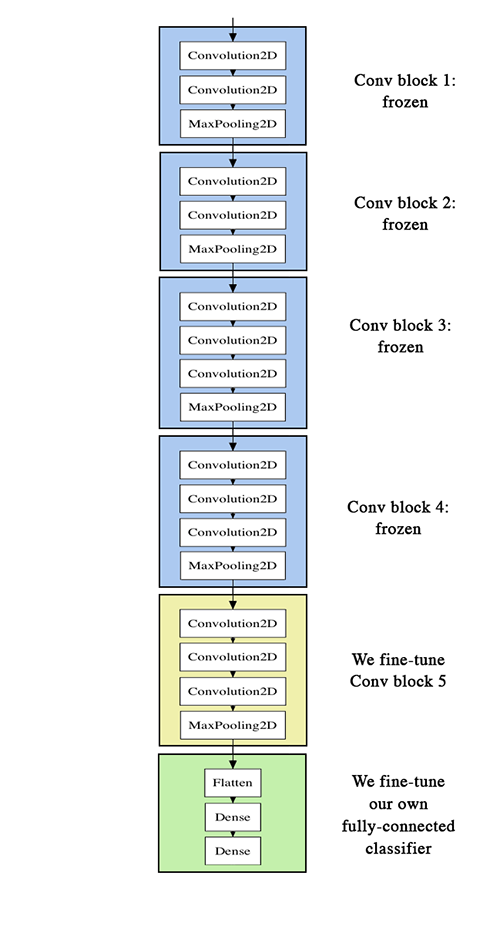

Note that:

-In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.

-We choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).

-Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [103]:
#Using generated model with layers of vgg

input_tensor = Input(shape=(150,150,3))
base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
print('VGG model')
base_model.summary()

VGG model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         


In [101]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights('fc_model.h5') #optional - to load the already saved weights
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 15 layers (up to the conv block 4) to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model.compile(loss='binary_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

print('\nAugmenting train data')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


print('\nScaling test data')
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


Augmenting train data
Found 2000 images belonging to 2 classes.

Scaling test data
Found 800 images belonging to 2 classes.
Epoch 1/4
125/125 [==============================] - 511s - loss: 0.2510 - acc: 0.8935 - val_loss: 0.2101 - val_acc: 0.9237
Epoch 2/4
125/125 [==============================] - 515s - loss: 0.2185 - acc: 0.9105 - val_loss: 0.1886 - val_acc: 0.9263
Epoch 3/4
125/125 [==============================] - 522s - loss: 0.1677 - acc: 0.9285 - val_loss: 0.1991 - val_acc: 0.9313
Epoch 4/4
125/125 [==============================] - 501s - loss: 0.1385 - acc: 0.9490 - val_loss: 0.2205 - val_acc: 0.9250


In [102]:
model.save_weights('VGG_cats_Vs_dogs.h5')